In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow import keras
from tensorflow.keras import Model, Input, optimizers

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



In [2]:
import os
print(os.listdir("./aerial-cactus-identification"))

['sample_submission.csv', 'test', 'test.zip', 'train', 'train.csv', 'train.zip']


In [3]:
dataset = pd.read_csv('./aerial-cactus-identification/train.csv')


train_dir = os.listdir("./aerial-cactus-identification/train")
test_dir = os.listdir("./aerial-cactus-identification/test")

#train_dir, test_dir
dataset.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
#retrieving the images and storing them in the arrays
data = []
labels = []

for i in train_dir:
    try:
    
        image = cv2.imread("./aerial-cactus-identification/train/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        
        data.append(np.array(resize_img))
        
        labels.append(dataset[dataset['id'] == i]['has_cactus'].values[0])
        
        
    except AttributeError:
        print('Error')

In [5]:
cactus = np.array(data)
labels = np.array(labels)
cactus.shape,labels.shape

((17500, 64, 64, 3), (17500,))

In [6]:
#Shuffle the data
cactus,labels = shuffle(cactus,labels)


In [7]:
cactus = cactus.astype("float32")/255
labels = tf.keras.utils.to_categorical(labels)


In [8]:
x_train,x_test,y_train,y_test = train_test_split(cactus,labels,test_size=0.2,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((14000, 64, 64, 3), (3500, 64, 64, 3), (14000, 2), (3500, 2))

In [9]:
input_tensor = Input(shape=x_train.shape[1:])

mobilenet_model = keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Administrator\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [10]:
mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [11]:
last = mobilenet_model.output
x = Flatten()(last)
preds = Dense(2, activation='softmax')(x)

tuned_mobilenet_model = Model(mobilenet_model.input, preds)

In [12]:
tuned_mobilenet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [13]:
tuned_mobilenet_model.compile(optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = tuned_mobilenet_model.fit(x_train, y_train, batch_size=64, epochs=8, validation_split=0.15)

Train on 11900 samples, validate on 2100 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/8
11900/11900 [==============================] - 876s 74ms/sample - loss: 0.0892 - acc: 0.9737 - val_loss: 1.2664 - val_acc: 0.8205
Epoch 2/8
11900/11900 [==============================] - 476s 40ms/sample - loss: 0.0286 - acc: 0.9912 - val_loss: 0.0224 - val_acc: 0.9924
Epoch 3/8
11900/11900 [==============================] - 479s 40ms/sample - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0225 - val_acc: 0.9938
Epoch 4/8
11900/11900 [==============================] - 481s 40ms/sample - loss: 0.0065 - acc: 0.9973 - val_loss: 0.0302 - val_acc: 0.9919
Epoch 5/8
11900/11900 [==============================] - 480s 40ms/sample - loss: 0.0096 - acc: 0.9971 - val_loss: 0.0621 - val_acc: 0.9824
Epoch 6/8
11900/11900 [==============================] - 478s 40ms/sample - loss: 0.0121 - acc: 0.9963 - val_loss: 0.0095 - val_acc: 0.9967
Epoch 7/8
11900/11900 [==============================] - 480s 4

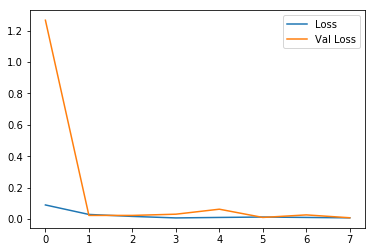

In [15]:
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label="Val Loss")
plt.legend()

In [16]:
accuracy  = tuned_mobilenet_model.evaluate(x_test,y_test)
print("Test Accuracy:-",accuracy)

3500/3500 [==============================] - 19s 5ms/sample - loss: 0.0128 - acc: 0.9974
Test Accuracy:- [0.012845490862055954, 0.9974286]


In [17]:
#retrieving the images and storing them in the arrays
test_data = []

test_df = pd.read_csv('./aerial-cactus-identification/sample_submission.csv')
images = test_df['id'].values

for i in images:
    try:
    
        image = cv2.imread("./aerial-cactus-identification/test/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((64 , 64))
        
        test_data.append(np.array(resize_img))
                
        
    except AttributeError:
        print('Error')

In [18]:
test_cactus = np.array(test_data)
test_cactus = test_cactus.astype("float32")/255


In [19]:
test_cactus.shape

(4000, 64, 64, 3)

In [20]:
pred = tuned_mobilenet_model.predict(test_cactus)
test_df['has_cactus'] = pred
test_df.to_csv('aerial-cactus-submission.csv', index = False)